#**Install Library**

In [ ]:
!pip install pysal
!pip install esda
!pip install contextily

#**Import Library**

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import esda
import pysal.lib

#**Load Dataset**

In [ ]:
import geopandas as gpd

# Load GeoJSON data
geojson_url = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/California/cnty19_1.shp"
california_map = gpd.read_file(geojson_url)

# Perform spatial data operations
# Create a spatial weights matrix
w = pysal.lib.weights.Queen.from_dataframe(california_map, use_index=True)

california_map.head(10)

/usr/local/lib/python3.10/dist-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
 There are 11 islands with ids: 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68.
  warnings.warn(message)


,OBJECTID,COUNTY_NAM,COUNTY_ABB,COUNTY_NUM,COUNTY_COD,COUNTY_FIP,ISLAND,GlobalID,SHAPE_Leng,SHAPE_Area,geometry
0,1,Alameda,ALA,1,01,001,None,{E6F92268-D2DD-4CFB-8B79-5B4B2F07C559},3.089987e+05,-3.402787e+09,"POLYGON ((-13611173.233 4566017.932, -13611061..."
1,2,Alpine,ALP,2,02,003,None,{870479B2-480A-494B-8352-AD60578839C1},2.748885e+05,-3.146939e+09,"POLYGON ((-13312326.921 4680816.110, -13312311..."
2,3,Amador,AMA,3,03,005,None,{4F45B3A6-BE10-461C-8945-6B2AAA7119F6},3.617084e+05,-2.562635e+09,"POLYGON ((-13366405.546 4679183.529, -13366408..."
3,4,Butte,BUT,4,04,007,None,{44FBA680-AECC-4E04-A499-29D69AFFBD4A},5.265471e+05,-7.339348e+09,"POLYGON ((-13478186.664 4807593.081, -13478502..."
4,5,Calaveras,CAL,5,05,009,None,{D11EF739-4A1E-414E-BFD1-E7DCD56CD61E},3.706376e+05,-4.351069e+09,"POLYGON ((-13360333.217 4641182.754, -13360329..."
5,6,Colusa,COL,6,06,011,None,{7BB40E7D-335A-4E8F-AABA-F003090D32EF},3.861916e+05,-4.992906e+09,"POLYGON ((-13568737.197 4776816.356, -13568737..."
6,7,Contra Costa,CC,7,07,013,None,{36D6618E-1D85-423D-81C5-D5FADE320099},3.217172e+05,-3.348831e+09,"POLYGON ((-13533539.659 4592151.386, -13533506..."
7,8,Del Norte,DEL,8,08,015,None,{1C9D9309-A72C-464F-9981-FE8358F354AC},3.913500e+05,-4.723608e+09,"POLYGON ((-13778334.019 5160379.081, -13775920..."
8,9,El Dorado,ELD,9,09,017,None,{8C7709F7-3E81-4245-85D6-3FBC6EBD7261},4.726026e+05,-7.635355e+09,"POLYGON ((-13358615.916 4731342.630, -13358536..."
9,10,Fresno,FRE,10,10,019,None,{F57A290A-F11E-4B3B-A53B-E8E4C2284BBB},1.110071e+06,-2.429841e+10,"POLYGON ((-13249238.478 4520776.442, -13249157..."


In [ ]:
import geopandas as gpd

# URL GeoJSON
geojson_url = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/California/California_County_Boundaries.geojson"

# Membaca file GeoJSON
california_counties = gpd.read_file(geojson_url)

# Menampilkan beberapa baris pertama data
california_counties.head(5)

california_counties.to_csv('california_counties.csv', index=False)


In [ ]:
# importing libraries
import pandas as pd # Reading csv file
from shapely.geometry import Point # Shapely for converting latitude/longtitude to geometry
import geopandas as gpd # To create GeodataFrame

# Baca dataset
dataset = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/California/usgs_california_1952_2022.csv"
df = pd.read_csv(dataset)

# creating a geometry column
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]

# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}

# Creating a Geographic data frame
gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

gdf.head(10)

df=gdf

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
# Konversi kolom 'time' ke format datetime
df['time'] = pd.to_datetime(df['time'])

# Seleksi data hanya untuk tahun 1968 - 2018
df_selected = df[(df['time'].dt.year >= 1968) & (df['time'].dt.year <= 2018)].copy()

# Memperbarui kolom 'city' dengan menggunakan .loc
df_selected['city'] = df_selected['place'].str.split(',').str[0].str.split('of').str[-1].str.strip()

df_selected['year'] = df_selected['time'].dt.year

# Mengambil hanya kolom yang diinginkan
df_selected = df_selected[['time','year' , 'latitude', 'longitude', 'place', 'city','depth', 'mag', 'magType','geometry']]
df_selected.head()

,time,year,latitude,longitude,place,city,depth,mag,magType,geometry
85,2018-07-05 15:17:36.947000+00:00,2018,35.894500,-115.775800,"15 km WNW of Sandy Valley, Nevada",Sandy Valley,8.60,4.50,ml,POINT (-115.77580 35.89450)
86,2018-04-05 19:29:16.220000+00:00,2018,33.819833,-119.734000,"31km SW of Santa Cruz Is. (E end), CA",Santa Cruz Is. (E end),9.82,5.29,mw,POINT (-119.73400 33.81983)
87,2017-11-13 19:31:29.050000+00:00,2017,36.630500,-121.244333,"18 km SSE of Tres Pinos, California",Tres Pinos,6.31,4.58,mw,POINT (-121.24433 36.63050)
88,2016-12-28 09:13:47.243000+00:00,2016,38.377700,-118.895700,"28 km SW of Hawthorne, Nevada",Hawthorne,8.80,5.50,ml,POINT (-118.89570 38.37770)
89,2016-12-28 08:22:12.208000+00:00,2016,38.390400,-118.897200,"28 km WSW of Hawthorne, Nevada",Hawthorne,12.20,5.60,ml,POINT (-118.89720 38.39040)


In [ ]:
# Kelompokkan data berdasarkan longitude dan latitude, kemudian hitung jumlah kejadian gempa di setiap kelompok
gempa_by_location = df_selected.groupby('city').size().reset_index(name='jumlah_kejadian')

# Tampilkan hasilnya
gempa_by_location.head(10)

,city,jumlah_kejadian
0,1971 San Fernando Earthquake,1
1,1987 Whittier Narrows Earthquake,1
2,Agua Dulce,8
3,Alamo,4
4,Alum Rock,1
5,Anza,6
6,Aptos Hills-Larkin Valley,1
7,Aromas,5
8,Arvin,1
9,Aspen Springs,20


In [ ]:
# Kelompokkan data berdasarkan longitude dan latitude, kemudian hitung jumlah kejadian gempa di setiap kelompok
w = df_selected['city'].value_counts()

city = pd.DataFrame({'Var1': w.index, 'Freq': w.values})

# Menampilkan panjang unik dari kolom 'Var1'
panjang_unik = len(city['Var1'])
print(panjang_unik)

229


In [ ]:
districts = california_map.merge(city, left_on='COUNTY_NAM', right_on='Var1', how='left')

# Mengganti nilai-nilai yang hilang (NA) dalam kolom 'Freq' dengan 0
districts['Freq'].fillna(0, inplace=True)

# Menampilkan panjang kolom 'Freq'
panjang_freq = len(districts['Freq'])
city.head(100)

,Var1,Freq
0,Beatty,132
1,Rachel,55
2,Indian Springs,39
3,Mammoth Lakes,25
4,Ludlow,21
...,...,...
95,Caliente,2
96,Little Lake,2
97,Ocotillo Wells,2
98,Kingston,2


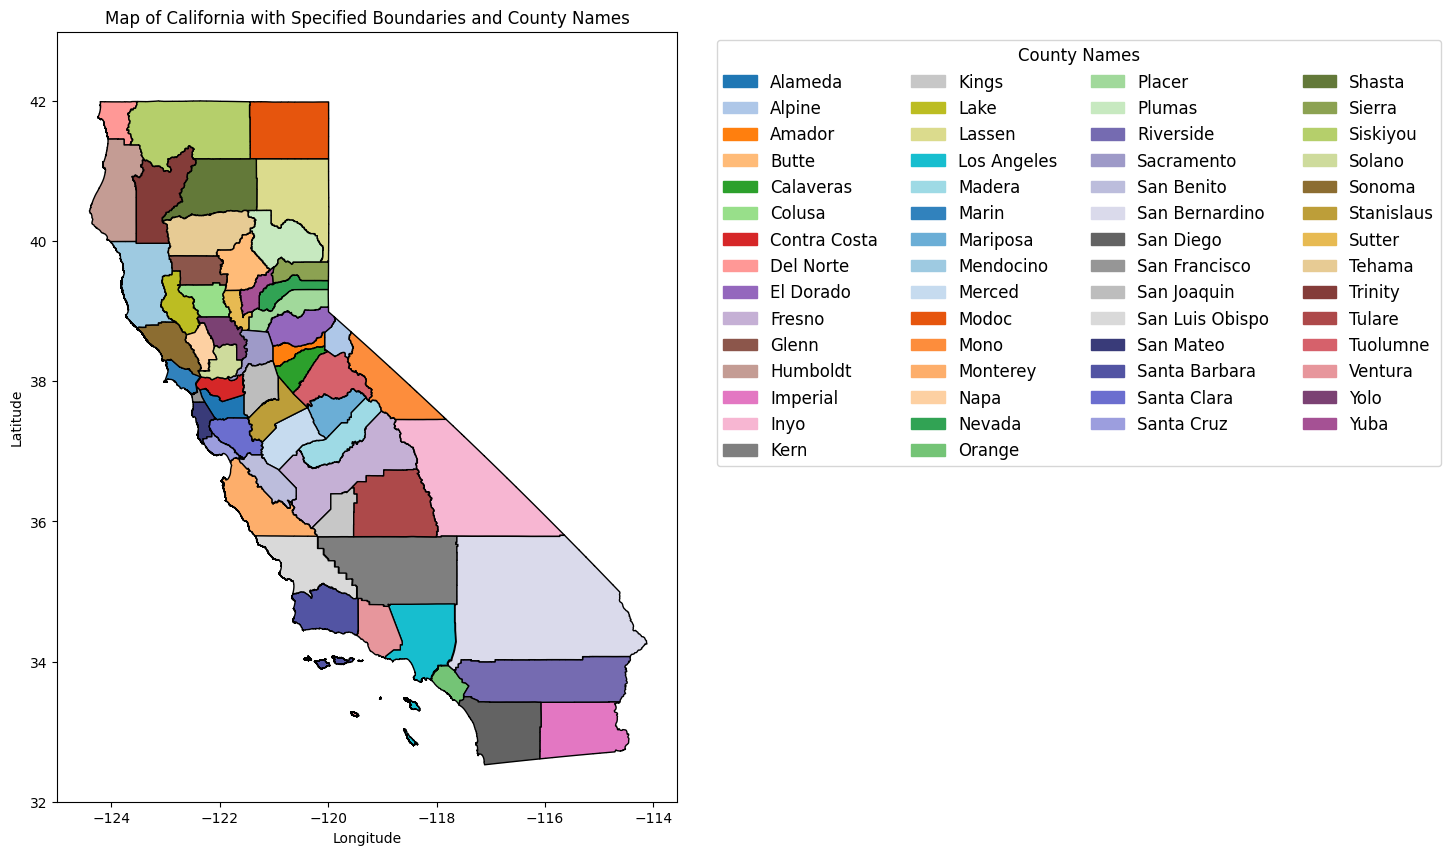

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import cm, colors

# Load GeoJSON data
geojson_url = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/California/California_County_Boundaries.geojson"
california_map = gpd.read_file(geojson_url)

# Get unique county names and count
county_names = california_map['COUNTY_NAME'].unique()
num_counties = len(county_names)

# Generate a colormap with a unique color for each county name
cmap = colors.ListedColormap(cm.tab20.colors + cm.tab20c.colors + cm.tab20b.colors, name='tab60')
colors = cmap(range(num_counties))
county_color_map = {name: color for name, color in zip(county_names, colors)}

# Plot the map
fig, ax = plt.subplots(figsize=(15, 10))

# Plot each county with a different color
for name in county_names:
    county_data = california_map[california_map['COUNTY_NAME'] == name]
    county_data.plot(ax=ax, color=county_color_map[name], edgecolor='black', label=name)

# Create legend patches and labels
legend_patches = [Patch(color=county_color_map[name], label=name) for name in county_names]

# Add legend outside the plot with 4 columns
ax.legend(handles=legend_patches, title='County Names', title_fontsize='large', fontsize='large', loc='upper left', bbox_to_anchor=(1.05, 1), ncol=4)

# Set the limits for longitude and latitude
min_lat, min_lon = 32, -125
max_lat, max_lon = 42.99, -113.56
ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)

# Add labels and title
plt.title('Map of California with Specified Boundaries and County Names')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()


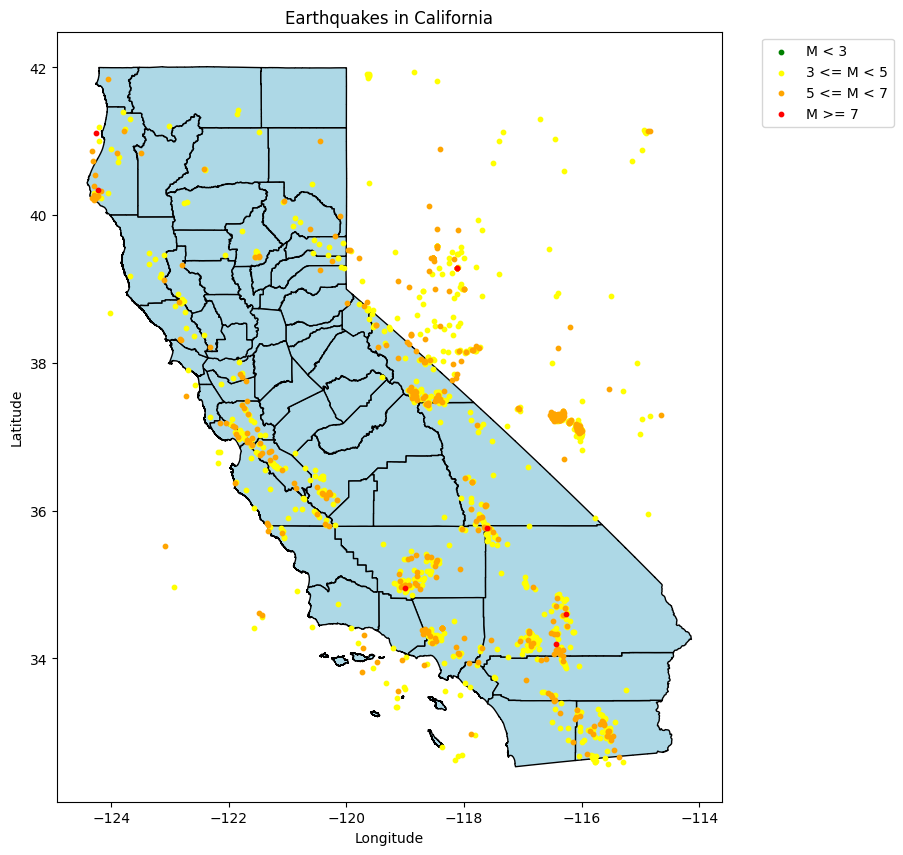

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Muat dataset gempa
dataset_url = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/California/usgs_california_1952_2022.csv"
gempa_df = pd.read_csv(dataset_url)

# Muat data peta California
geojson_url = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/California/California_County_Boundaries.geojson"
california_map = gpd.read_file(geojson_url)

# Buat plot
fig, ax = plt.subplots(figsize=(15, 10))

# Plot peta California
california_map.plot(ax=ax, color='lightblue', edgecolor='black')

# Tentukan rentang magnitudo
rentang_magnitudo = [(0, 3), (3, 5), (5, 7), (7, float('inf'))]
warna = ['green', 'yellow', 'orange', 'red']
label = ['M < 3', '3 <= M < 5', '5 <= M < 7', 'M >= 7']

# Plot kejadian gempa sesuai dengan rentang magnitudo
for i in range(len(rentang_magnitudo)):
    rentang = rentang_magnitudo[i]
    warna_kejadian = warna[i]
    label_kejadian = label[i]
    kejadian = gempa_df[(gempa_df['mag'] >= rentang[0]) & (gempa_df['mag'] < rentang[1])]
    ax.scatter(kejadian['longitude'], kejadian['latitude'], color=warna_kejadian, marker='o', s=10, label=label_kejadian)

# Tambahkan legenda
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

# Atur judul dan label
ax.set_title('Earthquakes in California')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Tampilkan plot
plt.show()


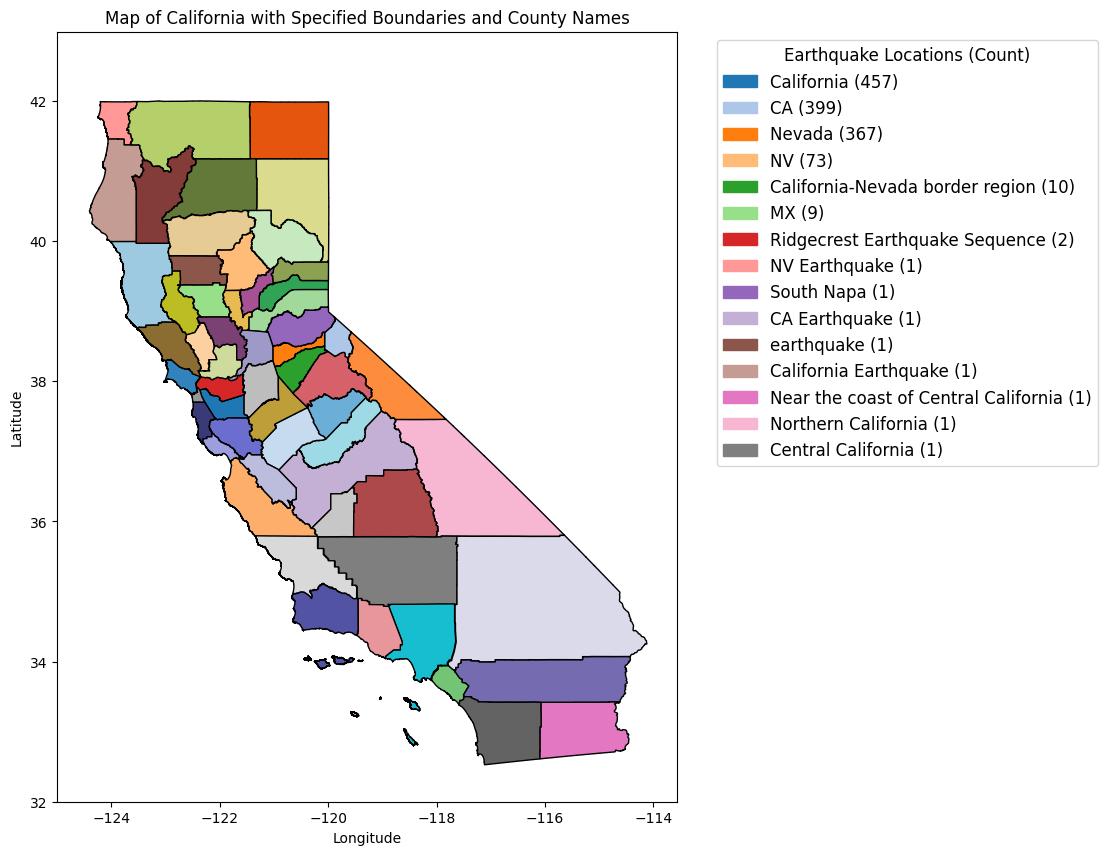

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import cm, colors

# Load GeoJSON data
geojson_url = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/California/California_County_Boundaries.geojson"
california_map = gpd.read_file(geojson_url)

# Get unique county names and count
county_names = california_map['COUNTY_NAME'].unique()
num_counties = len(county_names)

# Generate a colormap with a unique color for each county name
cmap = colors.ListedColormap(cm.tab20.colors + cm.tab20c.colors + cm.tab20b.colors, name='tab60')
colors = cmap(range(num_counties))
county_color_map = {name: color for name, color in zip(county_names, colors)}

# Plot the map
fig, ax = plt.subplots(figsize=(15, 10))

# Plot each county with a different color
for name in county_names:
    county_data = california_map[california_map['COUNTY_NAME'] == name]
    county_data.plot(ax=ax, color=county_color_map[name], edgecolor='black', label=name)

# Load earthquake data
earthquake_dataset_url = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/California/usgs_california_1952_2022.csv"
earthquake_df = pd.read_csv(earthquake_dataset_url)

# Get unique locations and count
earthquake_df['location'] = earthquake_df['place'].str.split(',').str[-1].str.strip()
location_counts = earthquake_df['location'].value_counts()

# Create legend patches and labels for earthquake locations with different colors
legend_patches_locations = []
colors = cm.tab20.colors + cm.tab20c.colors + cm.tab20b.colors
for i, (location, count) in enumerate(location_counts.items()):
    color = colors[i % len(colors)]
    legend_patches_locations.append(Patch(label=f"{location} ({count})", color=color))

# Add legend for earthquake locations
ax.legend(handles=legend_patches_locations, title='Earthquake Locations (Count)', title_fontsize='large', fontsize='large', loc='upper left', bbox_to_anchor=(1.05, 1), ncol=1)

# Set the limits for longitude and latitude
min_lat, min_lon = 32, -125
max_lat, max_lon = 42.99, -113.56
ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)

# Add labels and title
plt.title('Map of California with Specified Boundaries and County Names')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()


/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


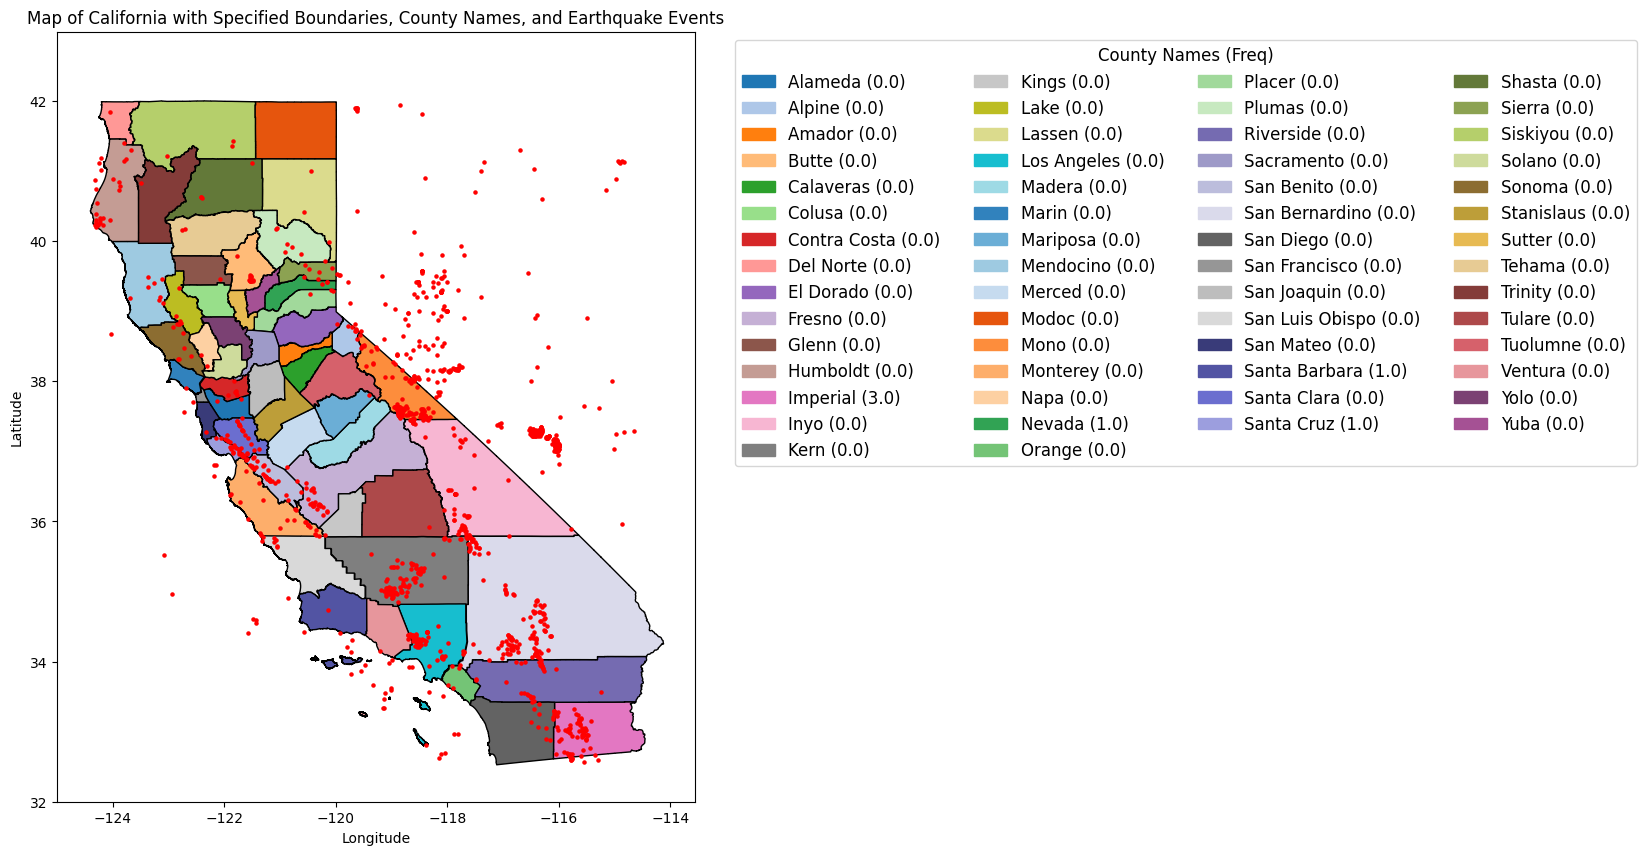

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Load earthquake data
earthquake_data_url = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/California/usgs_california_1952_2022.csv"
earthquake_df = pd.read_csv(earthquake_data_url)

# Convert longitude and latitude to geometry points
geometry = [Point(xy) for xy in zip(earthquake_df['longitude'], earthquake_df['latitude'])]
crs = {'init': 'epsg:4326'}  # Coordinate Reference System (CRS)

# Create GeoDataFrame
earthquake_gdf = gpd.GeoDataFrame(earthquake_df, crs=crs, geometry=geometry)

# Plot the map
fig, ax = plt.subplots(figsize=(15, 10))

# Plot each county with a different color
for name in county_names:
    county_data = california_map[california_map['COUNTY_NAME'] == name]
    county_data.plot(ax=ax, color=county_color_map[name], edgecolor='black', label=f'{name} ({districts[districts["COUNTY_NAM"] == name]["Freq"].values[0]})')

# Plot earthquake points
earthquake_gdf.plot(ax=ax, color='red', markersize=5, label='Earthquake')

# Create legend patches and labels
legend_patches = [Patch(color=county_color_map[name], label=f'{name} ({districts[districts["COUNTY_NAM"] == name]["Freq"].values[0]})') for name in county_names]

# Add legend outside the plot with 4 columns
ax.legend(handles=legend_patches, title='County Names (Freq)', title_fontsize='large', fontsize='large', loc='upper left', bbox_to_anchor=(1.05, 1), ncol=4)

# Set the limits for longitude and latitude
min_lat, min_lon = 32, -125
max_lat, max_lon = 42.99, -113.56
ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)

# Add labels and title
plt.title('Map of California with Specified Boundaries, County Names, and Earthquake Events')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()


/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


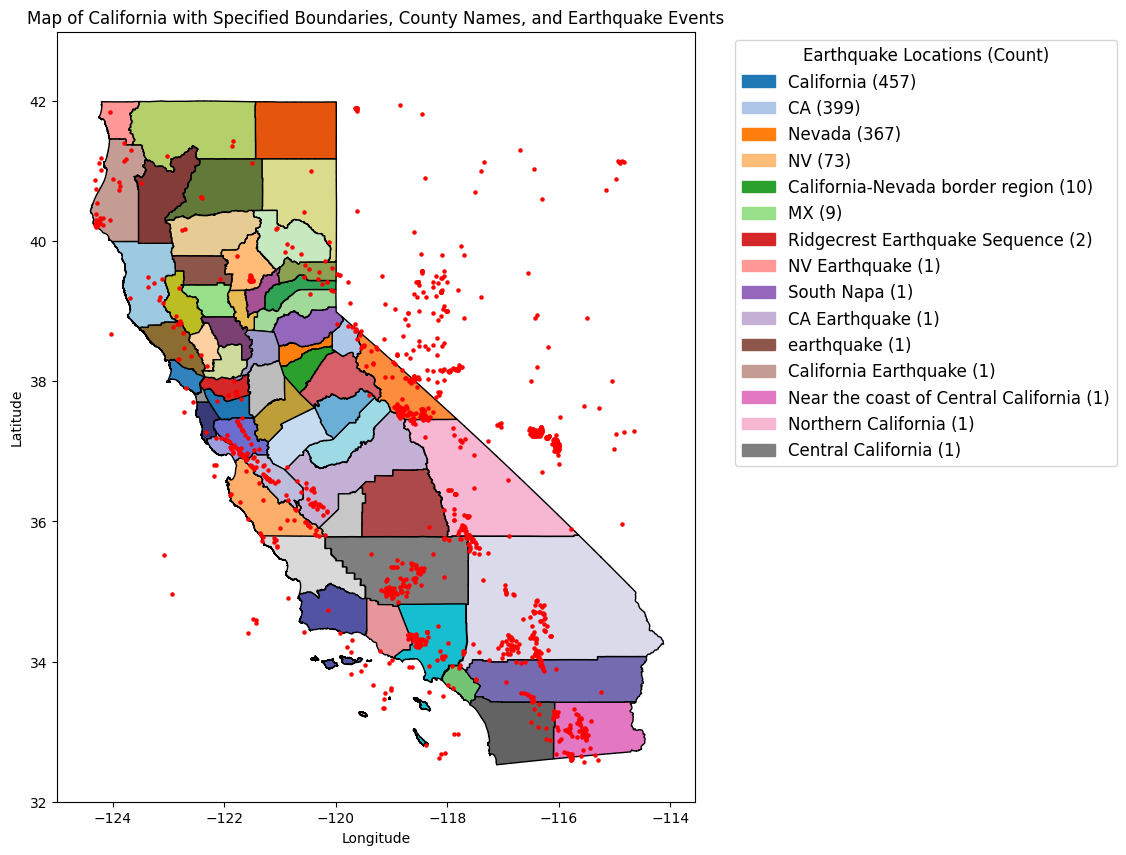

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Load earthquake data
earthquake_data_url = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/California/usgs_california_1952_2022.csv"
earthquake_df = pd.read_csv(earthquake_data_url)

# Convert longitude and latitude to geometry points
geometry = [Point(xy) for xy in zip(earthquake_df['longitude'], earthquake_df['latitude'])]
crs = {'init': 'epsg:4326'}  # Coordinate Reference System (CRS)

# Create GeoDataFrame
earthquake_gdf = gpd.GeoDataFrame(earthquake_df, crs=crs, geometry=geometry)

# Plot the map
fig, ax = plt.subplots(figsize=(15, 10))

# Plot each county with a different color
for name in county_names:
    county_data = california_map[california_map['COUNTY_NAME'] == name]
    county_data.plot(ax=ax, color=county_color_map[name], edgecolor='black', label=f'{name} ({districts[districts["COUNTY_NAM"] == name]["Freq"].values[0]})')

# Plot earthquake points
earthquake_gdf.plot(ax=ax, color='red', markersize=5, label='Earthquake')

# Create legend patches and labels
legend_patches = [Patch(color=county_color_map[name], label=f'{name} ({districts[districts["COUNTY_NAM"] == name]["Freq"].values[0]})') for name in county_names]

# Add legend outside the plot with 4 columns
#ax.legend(handles=legend_patches, title='County Names (Freq)', title_fontsize='large', fontsize='large', loc='upper left', bbox_to_anchor=(1.05, 1), ncol=4)

# Add legend for earthquake locations
ax.legend(handles=legend_patches_locations, title='Earthquake Locations (Count)', title_fontsize='large', fontsize='large', loc='upper left', bbox_to_anchor=(1.05, 1), ncol=1)


# Set the limits for longitude and latitude
min_lat, min_lon = 32, -125
max_lat, max_lon = 42.99, -113.56
ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)

# Add labels and title
plt.title('Map of California with Specified Boundaries, County Names, and Earthquake Events')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()


#**Spatial Autocorrelation**

In [ ]:
import geopandas
import contextily  # Background tiles


In [ ]:
# Load earthquake data
earthquake_data_url = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/California/usgs_california_1952_2022.csv"
ref = pd.read_csv(earthquake_data_url, index_col="place")

In [ ]:
# Load GeoJSON data
geojson_url = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/California/California_County_Boundaries.geojson"
lads = gpd.read_file(geojson_url).set_index("COUNTY_NAME")


In [ ]:
# Load earthquake data
earthquake_data_url = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/California/usgs_california_1952_2022.csv"
earthquake_df = pd.read_csv(earthquake_data_url)

# Load GeoJSON data
geojson_url = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/California/California_County_Boundaries.geojson"
california_counties = gpd.read_file(geojson_url)

# Merge earthquake data with GeoJSON data
merged_data = california_counties.merge(earthquake_df, left_on='COUNTY_NAME', right_on='place', how='inner')

# Now you can proceed with further analysis or visualization using merged_data


In [ ]:
merged_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1 entries, 0 to 0
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   OBJECTID         1 non-null      int64   
 1   COUNTY_NAME      1 non-null      object  
 2   COUNTY_ABBREV    1 non-null      object  
 3   COUNTY_NUM       1 non-null      int64   
 4   COUNTY_CODE      1 non-null      object  
 5   COUNTY_FIPS      1 non-null      object  
 6   ISLAND           0 non-null      object  
 7   GlobalID         1 non-null      object  
 8   SHAPE_Length     1 non-null      float64 
 9   SHAPE_Area       1 non-null      float64 
 10  geometry         1 non-null      geometry
 11  time             1 non-null      object  
 12  latitude         1 non-null      float64 
 13  longitude        1 non-null      float64 
 14  depth            1 non-null      float64 
 15  mag              1 non-null      float64 
 16  magType          1 non-null      object 

In [ ]:
db=merged_data

/usr/local/lib/python3.10/dist-packages/mapclassify/classifiers.py:1592: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 1.
  self.bins = quantile(y, k=k)


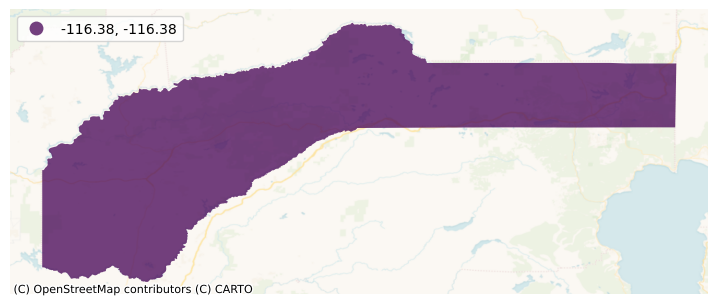

In [ ]:
# Set up figure and a single axis
f, ax = plt.subplots(1, figsize=(9, 9))

# Build choropleth
db.plot(
    column="longitude",  # Ganti dengan kolom yang sesuai untuk pemetaan
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax,
)

# Add basemap
contextily.add_basemap(
    ax,
    crs=db.crs,
    source=contextily.providers.CartoDB.VoyagerNoLabels,
)

# Remove axes
ax.set_axis_off()
